## Libraries

In [1]:
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import torch
import matplotlib.pyplot as plt
from rnn_lstm_model import RNN_LSTM_model
from train_model import train_model
from plot_scores import plot_scores
from loader import loader

c:\Users\henri\miniconda3\envs\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


## Load and save dataset

In [3]:
data = loader()

train_df = data["train"]
val_df = data["val"]
test_df = data["test"]
labels_df = data["labels"]

# Task 1: Data Preparation

## Data set

In [4]:
# Print number of examples
print(f"# train sentences: {len(train_df)}")
print(f"# validation sentences: {len(val_df)}")
print(f"# test sentences: {len(test_df)}")
print(f"\n{labels_df.to_string(index=False)}")

# train sentences: 16000
# validation sentences: 2000
# test sentences: 2000

 Index   Labels
     0  sadness
     1      joy
     2     love
     3    anger
     4     fear
     5 surprise


## Step 1: Dataset Preparation

### Label distribution

Number of classes: 6
Label Mapping: {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

Training Label Distribution:
text_label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


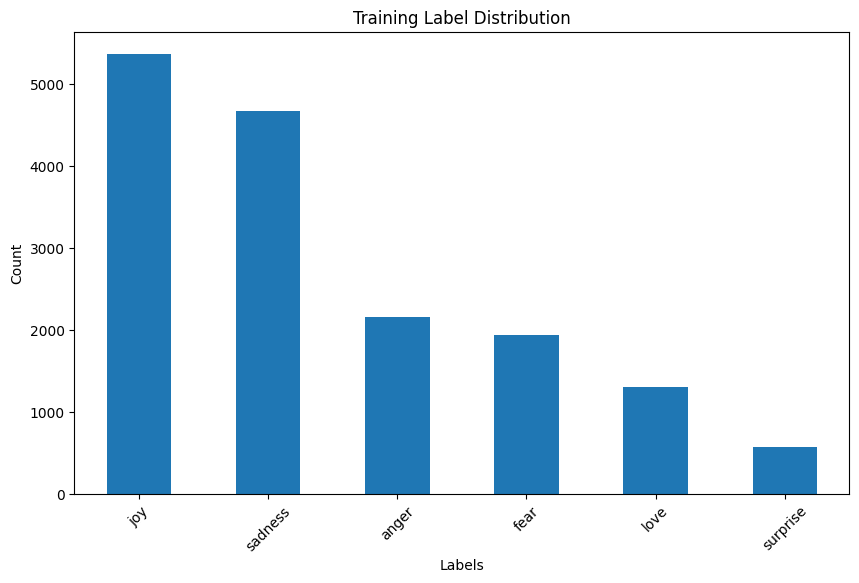

In [5]:
# Create a mapper for label numbers to text labels
num_classes = labels_df["Labels"].size
print(f"Number of classes: {num_classes}")
label_mapping = {index: label for index, label in labels_df.values}
print("Label Mapping:", label_mapping)

# Map numeric labels to text labels in the train, validation, and test sets
train_df["text_label"] = train_df["label"].map(label_mapping)
val_df["text_label"] = val_df["label"].map(label_mapping)
test_df["text_label"] = test_df["label"].map(label_mapping)

# Print the label distribution for training set
train_label_counts = train_df["text_label"].value_counts()
print("\nTraining Label Distribution:")
print(train_label_counts)

# Plot the label distribution
plt.figure(figsize=(10, 6))
train_label_counts.plot(kind="bar")
plt.title("Training Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

## Step 2: Tokenizing

### Tokenizer

In [6]:
tokenizer = RegexpTokenizer(r"[a-zA-Z0-9]+|[!?'´`]+") # characters that don’t match the pattern act as separators.
example_sentence = "This?.is,a:custom;tokenization example!<"
example_tokens = tokenizer.tokenize(example_sentence)
print(example_tokens)

['This', '?', 'is', 'a', 'custom', 'tokenization', 'example', '!']


### Tokenize each split

In [7]:
# Tokenize the training set
train_tokens = [tokenizer.tokenize(text) for text in train_df["text"]]
train_vocab = set(token for tokens in train_tokens for token in tokens)
print("First training sentence:", train_df["text"].iloc[0])
print("Tokenized:", train_tokens[0])

print("")

# Tokenize the validation set
val_tokens = [tokenizer.tokenize(text) for text in val_df["text"]]
val_vocab = set(token for tokens in val_tokens for token in tokens)
print("First validation sentence:", val_df["text"].iloc[0])
print("Tokenized:", val_tokens[0])

print("")

# Tokenize the test set
test_tokens = [tokenizer.tokenize(text) for text in test_df["text"]]
print("First test sentence:", test_df["text"].iloc[0])
print("Tokenized:", test_tokens[0])

# Output the missing words
print("")
missing_words = train_vocab - val_vocab
print(f"Number of words in training vocabulary: {len(train_vocab)}")
print(f"Number of words in validation vocabulary: {len(val_vocab)}")
print(f"Number of words missing in validation: {len(missing_words)}")

# Save missing words to a file
with open("missing_words.txt", "w") as file:
    for word in sorted(missing_words):
        file.write(f"{word}\n")

First training sentence: i didnt feel humiliated
Tokenized: ['i', 'didnt', 'feel', 'humiliated']

First validation sentence: im feeling quite sad and sorry for myself but ill snap out of it soon
Tokenized: ['im', 'feeling', 'quite', 'sad', 'and', 'sorry', 'for', 'myself', 'but', 'ill', 'snap', 'out', 'of', 'it', 'soon']

First test sentence: im feeling rather rotten so im not very ambitious right now
Tokenized: ['im', 'feeling', 'rather', 'rotten', 'so', 'im', 'not', 'very', 'ambitious', 'right', 'now']

Number of words in training vocabulary: 15212
Number of words in validation vocabulary: 4796
Number of words missing in validation: 11400


### Sentence length distribution

Length range for train: 2-66
Mean length for train: 19.17
Standard deviation for train: 120.70


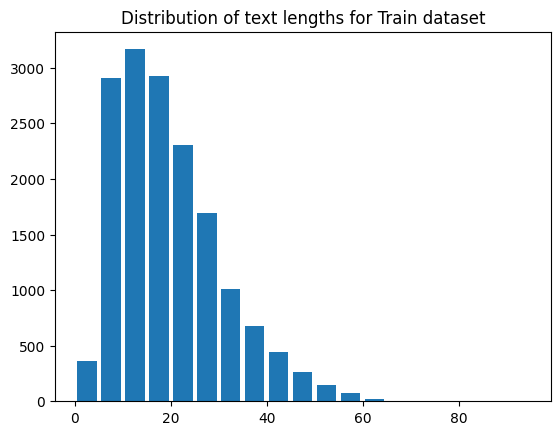

In [8]:
train_lengths = [len(tokens) for tokens in train_tokens]

print(f"Length range for train: {min(train_lengths)}-{max(train_lengths)}")
print(f"Mean length for train: {sum(train_lengths) / len(train_lengths):.2f}")
print(f"Standard deviation for train: {sum([(length - sum(train_lengths) / len(train_lengths)) ** 2 for length in train_lengths]) / len(train_lengths):.2f}")

plt.hist(train_lengths, bins=range(0, 100, 5), rwidth=0.8)
plt.title("Distribution of text lengths for Train dataset")
plt.show()

### Word frequency

In [9]:
from collections import Counter
from itertools import chain

flat_tokens = list(chain.from_iterable(train_tokens))
word_counts = Counter(flat_tokens)
top_n = 10
print(word_counts.most_common(top_n))

[('i', 25859), ('feel', 11183), ('and', 9589), ('to', 8972), ('the', 8370), ('a', 6200), ('feeling', 5112), ('that', 5112), ('of', 4990), ('my', 4283)]


## Step 3: Build a vocabulary

In [10]:
vocabulary = {"<PAD>": 0, "<UNK>": 1}
for tokens in train_tokens:
    for token in tokens:
        if token not in vocabulary:
            vocabulary[token] = len(vocabulary)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}")

reverse_vocab = {v: k for k, v in vocabulary.items()}

Vocabulary size: 15214


## Step 4: Encode all texts with the vocabulary

In [11]:
def encode_text(tokens): # i.e. words to integers
    return [vocabulary[token] if token in vocabulary else 1 for token in tokens]

train_encoded = [encode_text(tokens) for tokens in train_tokens]
val_encoded = [encode_text(tokens) for tokens in val_tokens]
test_encoded = [encode_text(tokens) for tokens in test_tokens]

## Step 5: Maximum sequence length

In [12]:
# Make all sentences equal length.
# If too small add zeroes at the end.
# If too long cut the end of the sentence.

max_length = 23
def pad_sequence(sequence):
    return sequence[:max_length] + [0] * (max_length - len(sequence)) 

train_padded = [pad_sequence(sequence) for sequence in train_encoded]
val_padded = [pad_sequence(sequence) for sequence in val_encoded]
test_padded = [pad_sequence(sequence) for sequence in test_encoded]

Epoch 1/10 | Train Loss: 106.8328 (acc. 32.59%) | Val Loss: 1.5818 (acc. 35.0%) | Time: 3s
Epoch 2/10 | Train Loss: 50.0935 (acc. 32.9%) | Val Loss: 1.584 (acc. 35.2%) | Time: 3s
Epoch 3/10 | Train Loss: 23.8182 (acc. 33.2%) | Val Loss: 1.5806 (acc. 35.1%) | Time: 3s
Epoch 4/10 | Train Loss: 11.5198 (acc. 33.09%) | Val Loss: 1.5919 (acc. 30.3%) | Time: 3s
Epoch 5/10 | Train Loss: 5.7326 (acc. 45.14%) | Val Loss: 1.1487 (acc. 56.95%) | Time: 3s
Epoch 6/10 | Train Loss: 2.9305 (acc. 60.55%) | Val Loss: 0.8437 (acc. 67.8%) | Time: 3s
Epoch 7/10 | Train Loss: 1.5949 (acc. 74.4%) | Val Loss: 0.6277 (acc. 78.05%) | Time: 3s
Epoch 8/10 | Train Loss: 0.9313 (acc. 84.38%) | Val Loss: 0.425 (acc. 85.45%) | Time: 3s
Epoch 9/10 | Train Loss: 0.6285 (acc. 88.88%) | Val Loss: 0.3307 (acc. 87.55%) | Time: 3s
Epoch 10/10 | Train Loss: 0.5115 (acc. 90.3%) | Val Loss: 0.3089 (acc. 88.65%) | Time: 3s
Total Training Time: 29s

Accuracy Score: 0.8865
F1-Score: 0.8862
Precision: 0.8873
Recall: 0.8865

Class

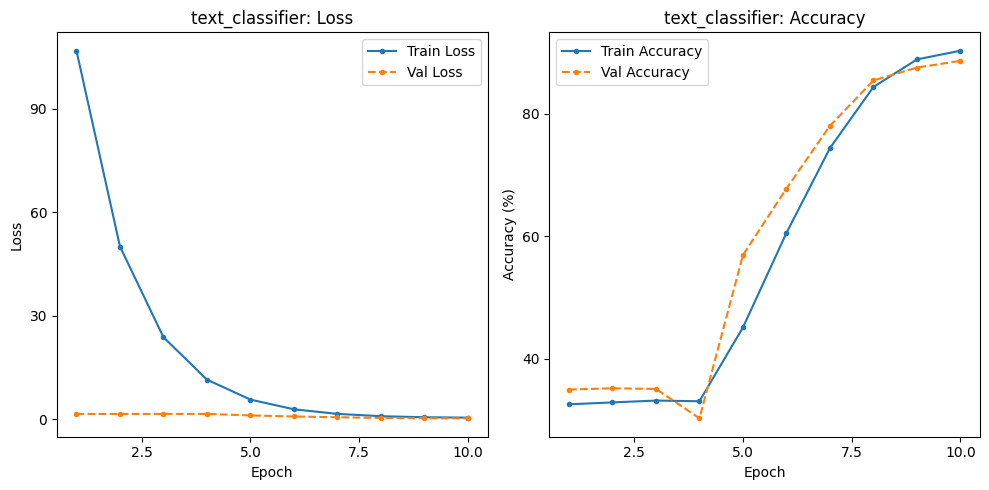

In [13]:
# Model
embedding_dim = 100
hidden_dim = 256
model = RNN_LSTM_model(vocab_size, embedding_dim, hidden_dim, num_classes)

label = "text_classifier"
batch_size = 32
num_epochs = 30
learning_rate = 0.0001

results = train_model(
    label=label,
    model=model,
    train_data=train_padded,
    val_data=val_padded,
    train_labels=train_df["label"].tolist(),
    val_labels=val_df["label"].tolist(),
    label_mapping=label_mapping,
    device=device,
    optimizer_type="Adam",
    learning_rate=0.001,
    weight_decay=0.0,
    reg_type="L2",
    reg_lambda=1e-4,
    num_epochs=10
)

plot_scores(results, label)
